This notebook plots the selected kmeans and GMM based on the explorations notebook and also calculates accuracy scores. 

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import sys
import pickle
from glob import glob
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.mask import mask
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Establish path for modules
sys.path.insert(0, '..\\modules\\')

# Import modules with custom functions
import calc_array_mask_test
import morph_indices

# Set font sizes for plots
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=16)

In [3]:
# For windows users
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [4]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "koumassi_focus_ps"

# Define paths to bands
band_path = '..\\data\\'+aoi+"\\"
outputs_path= os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
try:
    os.makedirs(kmeans_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

band_path directory already exists!


In [5]:
# Create raster stack of all bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [6]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()
    stack_out_meta = src.meta.copy()
    files_out_meta_test = src.meta.copy()

In [7]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1
files_out_meta_test['count']=1
files_out_meta_test['nodata']=-99999
# _test NDVI, NDWI, MSI files saved without using 'nodata' = -9999
# files_out_meta['nodata']=-9999

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

# Update stack_out_meta for writing out cloud masked band stack
stack_out_meta['nodata']=-99999

# k-means results

In [8]:
# Define k-means classifier
nclass = 8
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)
pickle.dump(clf_kmeans,open(kmeans_outputs_path+'pickle_kmeans', 'wb'))

In [9]:
# Reshape 8 band raster stack for input to k-means and GMM
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1,8)

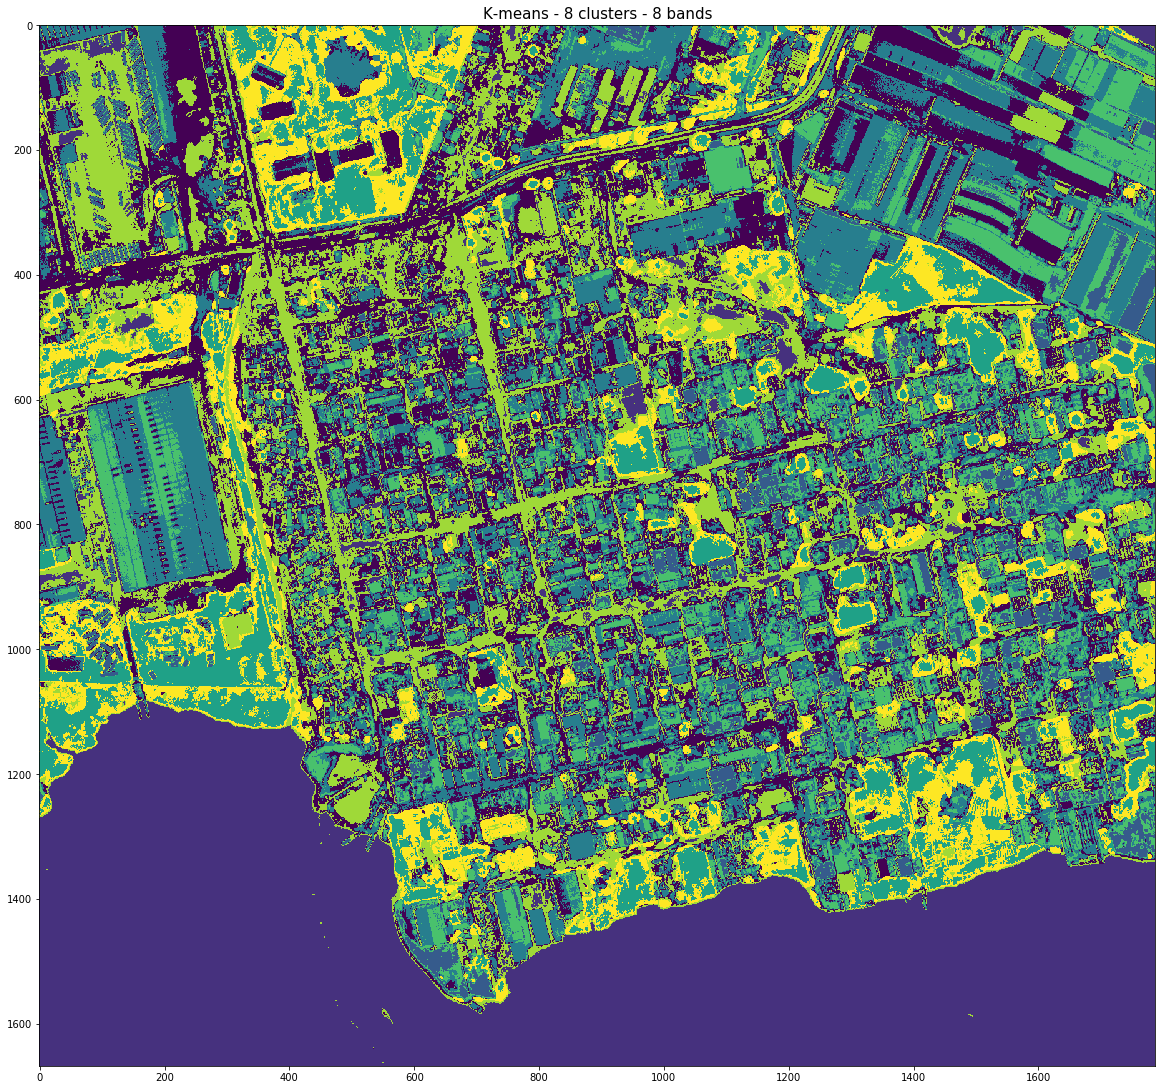

In [10]:
# Run k-means on the 8-band raster stack
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_all_bands = clf_kmeans.fit_predict(X_all_bands_stack, y=None)
predictedClass_all_bands += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_all_bands = predictedClass_all_bands.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_all_bands)
plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
plt.show()

# pred_data_shadow_free = pred_data_shadow_free[np.newaxis,:]
with rio.open(kmeans_outputs_path+'kmeans_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_all_bands.astype('float32'),1)

In [11]:
# Set paths
kmeans_file ="kmeans_all_bands"
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
kmeans_path = os.path.join(band_path, "outputs\\kmeans\\"+kmeans_file+".tif")

# Read in validation reference point shape files
validation_data_path = os.path.join(band_path,'validation\\')
sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_60perc.shp")
sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_40perc.shp")
sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"additional_validation_points.shp")

# Read in all validation data for 60%, 40% and all data sets
valid_60_data = pd.read_csv(validation_data_path+"additional_validation_points_60perc.csv")
valid_40_data = pd.read_csv(validation_data_path+"additional_validation_points_40perc.csv")
all_valid_data = pd.read_csv(validation_data_path+"additional_validation_points.csv")

In [12]:
# Update classes after looking at what each cluster represents
# 1 = shadow, 2 = flood, 3 = other
class8 = 3
class7 = 2 
class6 = 3
class5 = 3
class4 = 3
class3 = 3 
class2 = 1 
class1 = 3

# Accuracy on 60% of reference dataset

In [13]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)

sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_60_df = pd.DataFrame(arr)
# kmeans_60_df.head()

In [14]:
kmeans_valid = pd.concat([valid_60_data,kmeans_60_df], axis=1, sort=False)
kmeans_valid.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,2.0
1,2,2,2.0
2,3,1,2.0
3,4,1,2.0
4,5,1,2.0


In [15]:
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid.loc[kmeans_valid['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,2,2.0,1.0
1,2,2,2.0,1.0
2,3,1,2.0,1.0
3,4,1,2.0,1.0
4,5,1,2.0,1.0


In [16]:
ytest = kmeans_valid['ClassValue']
ypred = kmeans_valid['new']
accuracy_score(ytest, ypred)

0.8220338983050848

[[258  54   0]
 [ 53 182   5]
 [  0  14 142]]


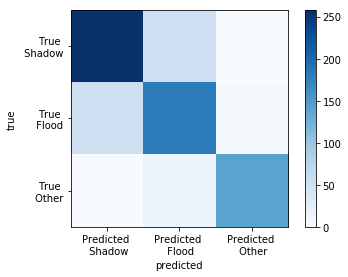

In [17]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [18]:
confusion_60 = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_60).to_csv(kmeans_outputs_path+kmeans_file+'confusion_60.csv')

# Accuracy on 40% of reference data

In [19]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_40perc.geometry.x)
y_coords = tuple(sample_pts_40perc.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_40_df = pd.DataFrame(arr)
# kmeans_40_df.head()

In [20]:
kmeans_valid_40 = pd.concat([valid_40_data,kmeans_40_df], axis=1, sort=False)
kmeans_valid_40.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid_40.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,1,2.0
1,2,1,2.0
2,3,1,2.0
3,4,1,2.0
4,5,1,2.0


In [21]:
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid_40.loc[kmeans_valid_40['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid_40.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,1,2.0,1.0
1,2,1,2.0,1.0
2,3,1,2.0,1.0
3,4,1,2.0,1.0
4,5,1,2.0,1.0


In [22]:
ytest = kmeans_valid_40['ClassValue']
ypred = kmeans_valid_40['new']
accuracy_score(ytest, ypred)

0.8283898305084746

[[169  41   0]
 [ 31 119   3]
 [  0   6 103]]


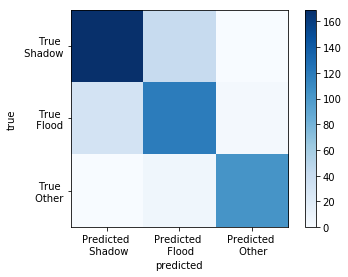

In [23]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [24]:
confusion_60 = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_60).to_csv(kmeans_outputs_path+kmeans_file+'confusion_40.csv')

# Accuracy on 100% of reference data

In [25]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_all.geometry.x)
y_coords = tuple(sample_pts_all.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_all_df = pd.DataFrame(arr)
kmeans_all_df.head()

,0
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0


In [26]:
kmeans_valid_all = pd.concat([all_valid_data,kmeans_all_df], axis=1, sort=False)
kmeans_valid_all.columns=["OBJECTID","ClassValue","Kmeans_Cluster"]
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,2.0
1,2,2,2.0
2,3,1,2.0
3,4,1,2.0
4,5,1,2.0


In [27]:
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 8.0,"new"] = class8
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 7.0,"new"] = class7
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 6.0,"new"] = class6
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 5.0,"new"] = class5
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 4.0,"new"] = class4
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 3.0,"new"] = class3
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 2.0,"new"] = class2
kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster'] == 1.0,"new"] = class1
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster,new
0,1,2,2.0,1.0
1,2,2,2.0,1.0
2,3,1,2.0,1.0
3,4,1,2.0,1.0
4,5,1,2.0,1.0


In [28]:
ytest = kmeans_valid_all['ClassValue']
ypred = kmeans_valid_all['new']
accuracy_score(ytest, ypred)

0.8245762711864407

[[427  95   0]
 [ 84 301   8]
 [  0  20 245]]


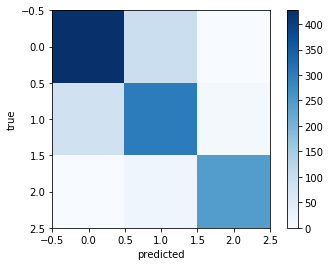

In [29]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [30]:
confusion_all = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_all).to_csv(kmeans_outputs_path+'confusion_all.csv')

In [31]:
# Calculate flooded surface area
flood_pix = (pred_data_all_bands==7).sum()
shadow_pix = (pred_data_all_bands==2).sum()
# no_data_pix = (index_comb==1).sum()
# building_pix = (index_comb==2).sum()
# veg_pix = (index_comb==3).sum()
# flood_pix = (index_comb==4).sum()
# shadow_pix = (index_comb==5).sum()

res = 0.46*0.46
flood_area = flood_pix*res
print('Flood area:',flood_area)
shadow_area = shadow_pix*res
print('Shadow area:',shadow_area)

Flood area: 103954.42480000001
Shadow area: 134417.2072


#  Gaussian Mixture Model

In [32]:
# Define GMM classifier
clf_gm = GaussianMixture(n_components=8)#.fit(X_ps).predict(X_ps)

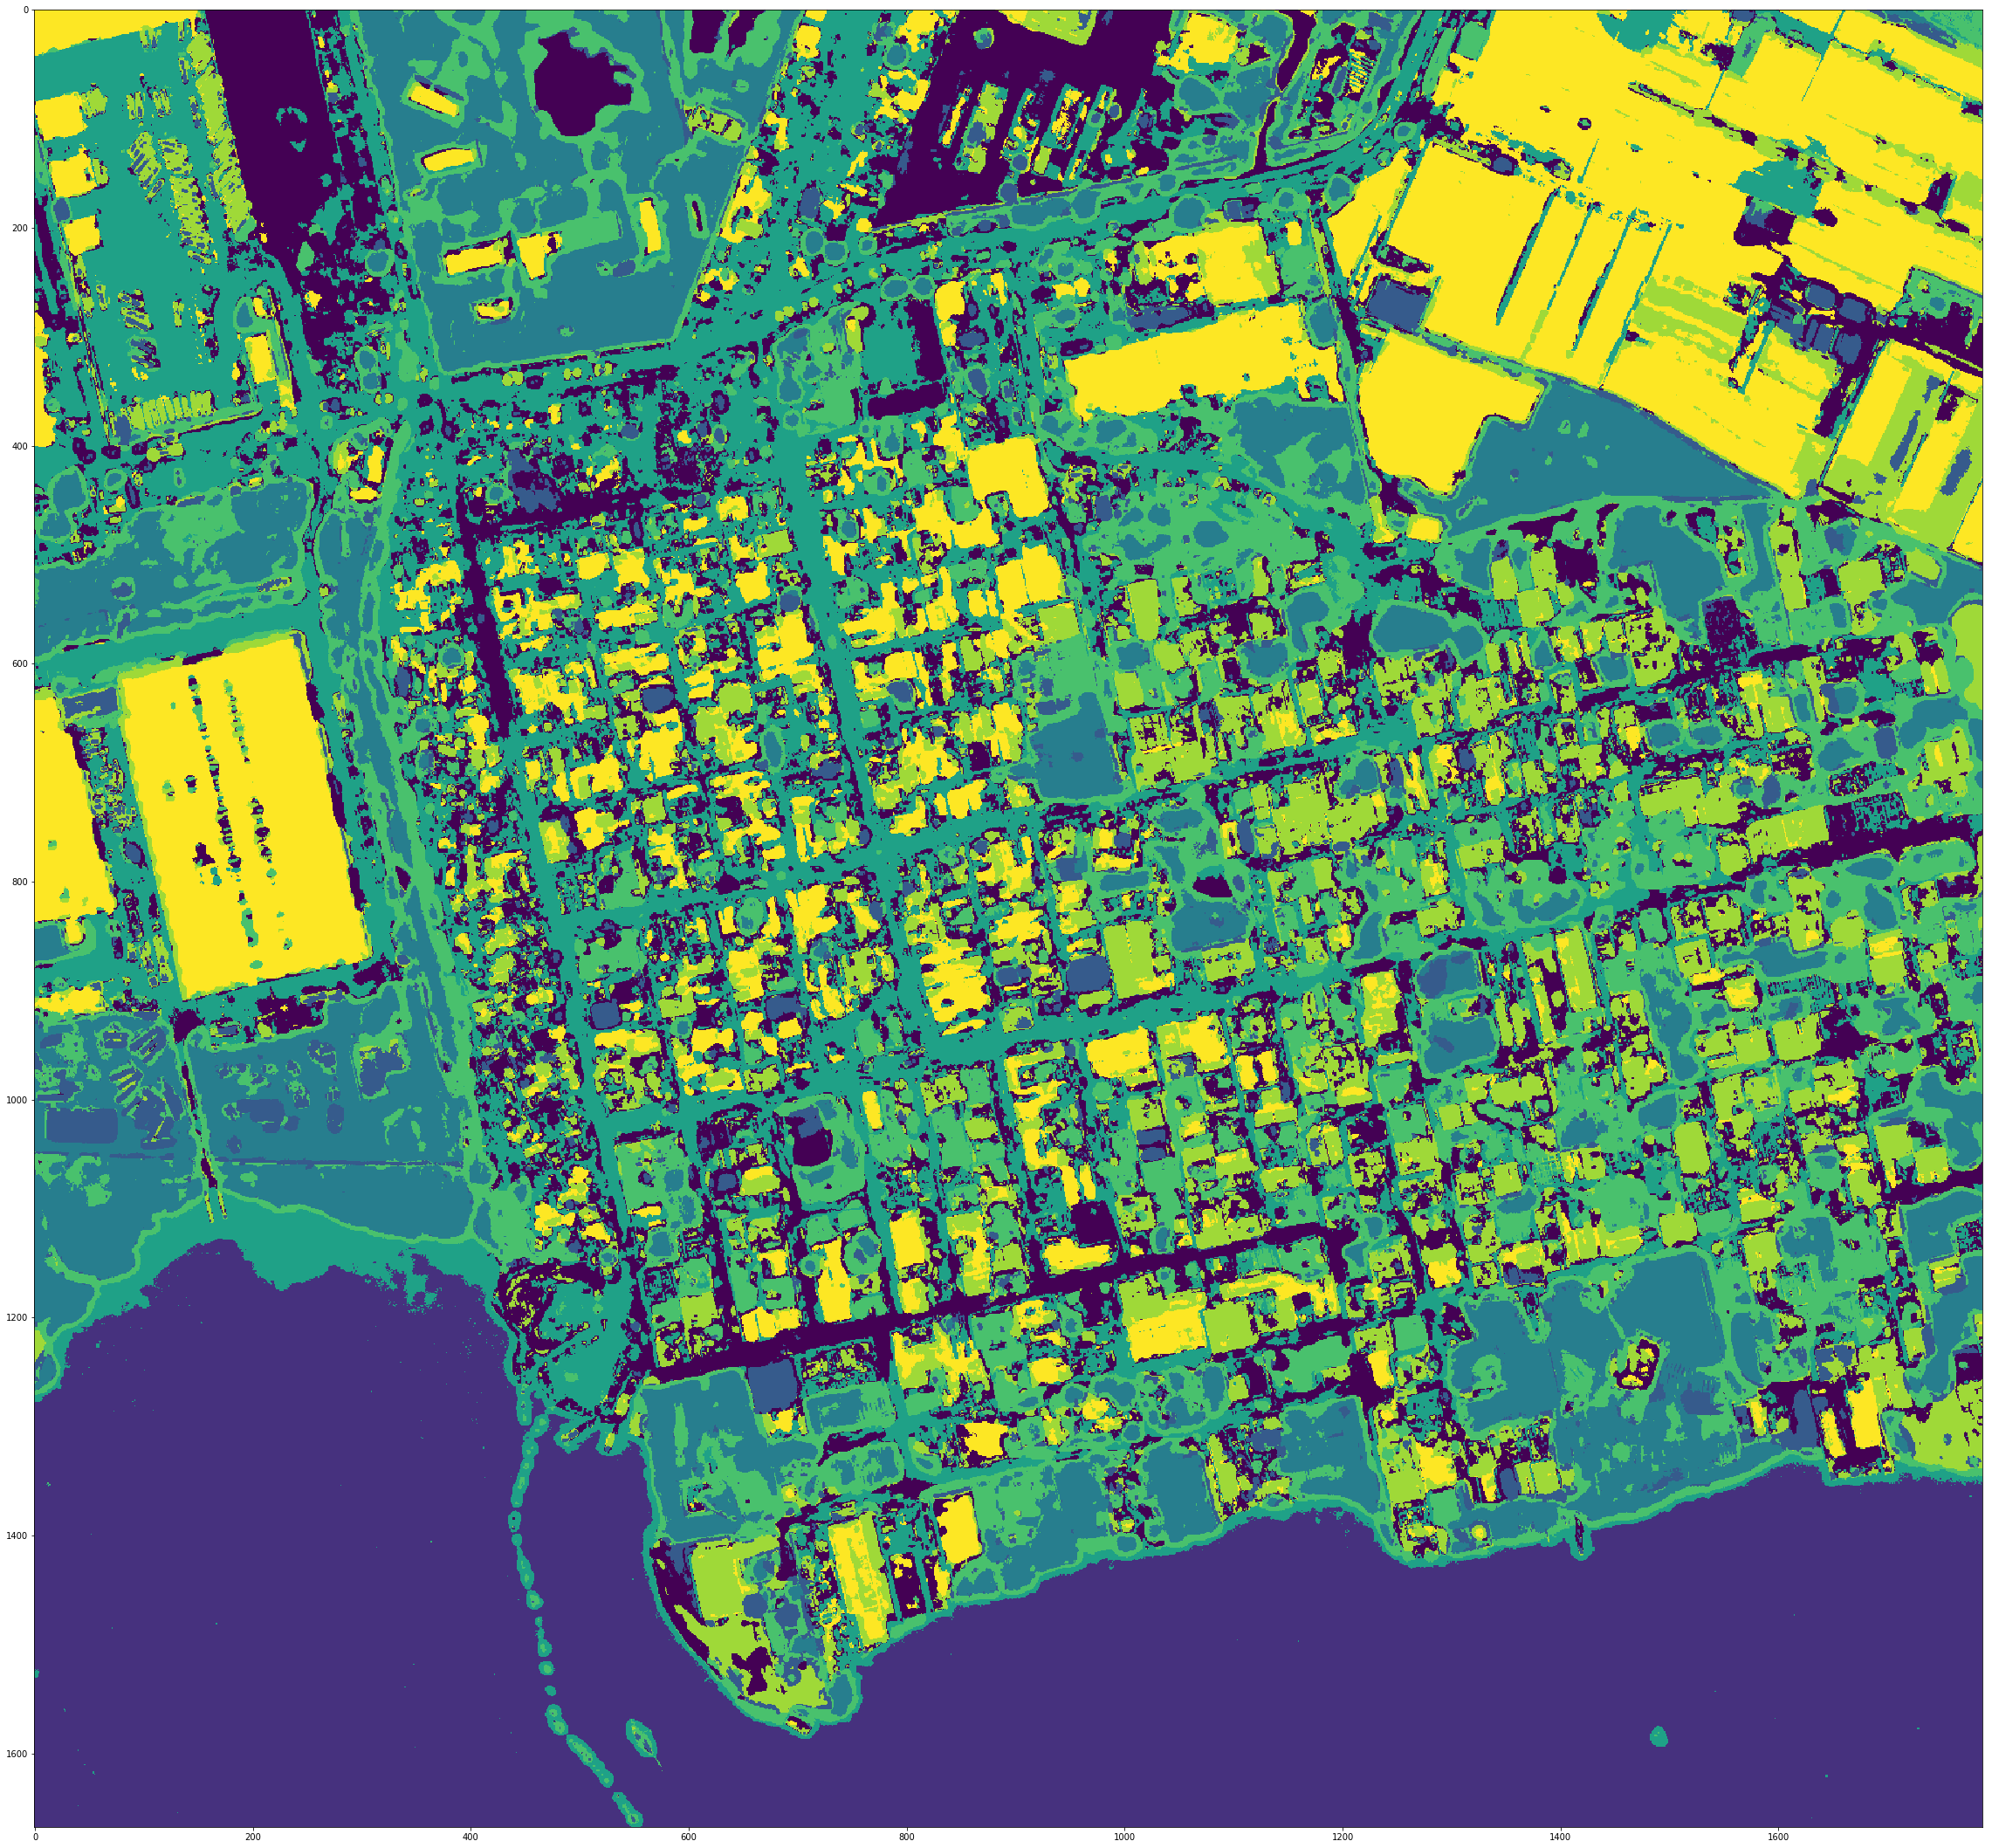

In [33]:
# Fit the GMM classifier to the 8-band stack
predictedClass_gm = clf_gm.fit_predict(X_all_bands_stack, y=None)
predictedClass_gm += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_gm)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()
with rio.open(kmeans_outputs_path+'gmm_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm.astype('float32'),1)

In [34]:
# Set paths
kmeans_file ="gmm_all_bands"
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
kmeans_path = os.path.join(band_path, "outputs\\kmeans\\"+kmeans_file+".tif")

# Read in validation reference point shape files
validation_data_path = os.path.join(band_path,'validation\\')
sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_60perc.shp")
sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\additional_validation_points_40perc.shp")
sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"additional_validation_points.shp")

# Read in all validation data for 60%, 40% and all data sets
valid_60_data = pd.read_csv(validation_data_path+"additional_validation_points_60perc.csv")
valid_40_data = pd.read_csv(validation_data_path+"additional_validation_points_40perc.csv")
all_valid_data = pd.read_csv(validation_data_path+"additional_validation_points.csv")

In [35]:
# Update classes after looking at what each cluster represents
# 1 = shadow, 2 = flood, 3 = other
class8 = 3
class7 = 2 
class6 = 3
class5 = 3
class4 = 3
class3 = 3 
class2 = 2 
class1 = 2

# Accuracy on 60% of reference dataset

In [36]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)

sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
gmm_60_df = pd.DataFrame(arr)
# kmeans_60_df.head()

In [37]:
gmm_valid = pd.concat([valid_60_data,gmm_60_df], axis=1, sort=False)
gmm_valid.columns=["OBJECTID","ClassValue","GMM_Cluster"]
gmm_valid.head()

,OBJECTID,ClassValue,GMM_Cluster
0,1,2,5.0
1,2,2,5.0
2,3,1,5.0
3,4,1,5.0
4,5,1,5.0


In [38]:
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 8.0,"new"] = class8
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 7.0,"new"] = class7
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 6.0,"new"] = class6
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 5.0,"new"] = class5
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 4.0,"new"] = class4
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 3.0,"new"] = class3
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 2.0,"new"] = class2
gmm_valid.loc[gmm_valid['GMM_Cluster'] == 1.0,"new"] = class1
gmm_valid.head()

,OBJECTID,ClassValue,GMM_Cluster,new
0,1,2,5.0,3.0
1,2,2,5.0,3.0
2,3,1,5.0,3.0
3,4,1,5.0,3.0
4,5,1,5.0,3.0


In [39]:
ytest = gmm_valid['ClassValue']
ypred = gmm_valid['new']
accuracy_score(ytest, ypred)

0.1765536723163842

[[  0   2 310]
 [  0  16 224]
 [  0  47 109]]


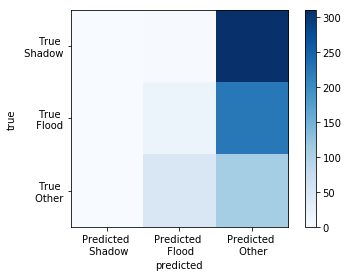

In [40]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [41]:
confusion_60 = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_60).to_csv(kmeans_outputs_path+kmeans_file+'confusion_60.csv')

# Accuracy on 40% of reference data

In [42]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_40perc.geometry.x)
y_coords = tuple(sample_pts_40perc.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
gmm_40_df = pd.DataFrame(arr)
# kmeans_40_df.head()

In [43]:
gmm_valid_40 = pd.concat([valid_40_data,kmeans_40_df], axis=1, sort=False)
gmm_valid_40.columns=["OBJECTID","ClassValue","GMM_Cluster"]
gmm_valid_40.head()

,OBJECTID,ClassValue,GMM_Cluster
0,1,1,2.0
1,2,1,2.0
2,3,1,2.0
3,4,1,2.0
4,5,1,2.0


In [44]:
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 8.0,"new"] = class8
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 7.0,"new"] = class7
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 6.0,"new"] = class6
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 5.0,"new"] = class5
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 4.0,"new"] = class4
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 3.0,"new"] = class3
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 2.0,"new"] = class2
gmm_valid_40.loc[gmm_valid_40['GMM_Cluster'] == 1.0,"new"] = class1
gmm_valid_40.head()

,OBJECTID,ClassValue,GMM_Cluster,new
0,1,1,2.0,2.0
1,2,1,2.0,2.0
2,3,1,2.0,2.0
3,4,1,2.0,2.0
4,5,1,2.0,2.0


In [45]:
ytest = gmm_valid_40['ClassValue']
ypred = gmm_valid_40['new']
accuracy_score(ytest, ypred)

0.5148305084745762

[[  0 210   0]
 [  0 153   0]
 [  0  19  90]]


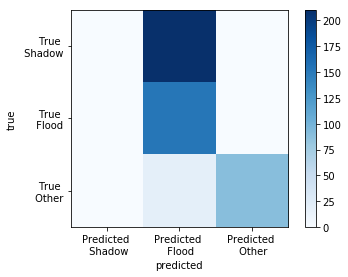

In [46]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Other'))
plt.yticks(np.arange(3), ('True \n Shadow','True \n Flood','True \n Other'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [47]:
confusion_40 = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_40).to_csv(kmeans_outputs_path+kmeans_file+'confusion_40.csv')

# Accuracy on 100% of reference data

In [48]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_all.geometry.x)
y_coords = tuple(sample_pts_all.geometry.y)
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
gmm_all_df = pd.DataFrame(arr)
gmm_all_df.head()

,0
0,5.0
1,5.0
2,5.0
3,5.0
4,5.0


In [49]:
gmm_valid_all = pd.concat([all_valid_data,gmm_all_df], axis=1, sort=False)
gmm_valid_all.columns=["OBJECTID","ClassValue","GMM_Cluster"]
gmm_valid_all.head()

,OBJECTID,ClassValue,GMM_Cluster
0,1,2,5.0
1,2,2,5.0
2,3,1,5.0
3,4,1,5.0
4,5,1,5.0


In [50]:
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 8.0,"new"] = class8
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 7.0,"new"] = class7
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 6.0,"new"] = class6
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 5.0,"new"] = class5
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 4.0,"new"] = class4
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 3.0,"new"] = class3
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 2.0,"new"] = class2
gmm_valid_all.loc[gmm_valid_all['GMM_Cluster'] == 1.0,"new"] = class1
gmm_valid_all.head()

,OBJECTID,ClassValue,GMM_Cluster,new
0,1,2,5.0,3.0
1,2,2,5.0,3.0
2,3,1,5.0,3.0
3,4,1,5.0,3.0
4,5,1,5.0,3.0


In [51]:
ytest = gmm_valid_all['ClassValue']
ypred = gmm_valid_all['new']
accuracy_score(ytest, ypred)

0.17542372881355933

[[  0   3 519]
 [  0  30 363]
 [  0  88 177]]


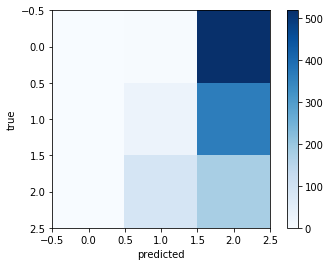

In [52]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [53]:
confusion_all = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_all).to_csv(kmeans_outputs_path+kmeans_file+'confusion_all.csv')

In [54]:
# Calculate flooded surface area
flood_pix = (pred_data_all_bands==7).sum()
flood1_pix = (pred_data_all_bands==2).sum()
flood2_pix = (pred_data_all_bands==1).sum()
# no_data_pix = (index_comb==1).sum()
# building_pix = (index_comb==2).sum()
# veg_pix = (index_comb==3).sum()
# flood_pix = (index_comb==4).sum()
# shadow_pix = (index_comb==5).sum()

res = 0.46*0.46
flood_area = (flood_pix+flood1_pix+flood2_pix)*res
flood_area

362325.6424